In [1]:
import pandas as pd 
import numpy as np
pd.options.display.float_format = '{:.5f}'.format
import warnings
warnings.filterwarnings(action = 'ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

from scipy import stats
import scipy.stats as stats
from scipy.stats import bartlett
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'statsmodels'

#### Dataset

In [151]:
kospi_all_wins = pd.read_csv('./dataset/kospi_all_wins.csv')
kospi_M1_wins = pd.read_csv('./dataset/kospi_bad_wins.csv')
kospi_M0_wins = pd.read_csv('./dataset/kospi_good_wins.csv')
kosdaq_all_wins = pd.read_csv('./dataset/kosdaq_all_wins.csv')
kosdaq_M1_wins = pd.read_csv('./dataset/kosdaq_bad_wins.csv')
kosdaq_M0_wins = pd.read_csv('./dataset/kosdaq_good_wins.csv')

In [152]:
kospi_M1_good_wins = kospi_M1_wins[kospi_M1_wins['target']==0]
kospi_M1_bad_wins = kospi_M1_wins[kospi_M1_wins['target']==1]

kospi_M0_good_wins = kospi_M0_wins[kospi_M0_wins['target']==0]
kospi_M0_bad_wins = kospi_M0_wins[kospi_M0_wins['target']==1]

kosdaq_M1_good_wins = kosdaq_M1_wins[kosdaq_M1_wins['target']==0]
kosdaq_M1_bad_wins = kosdaq_M1_wins[kosdaq_M1_wins['target']==1]

kosdaq_M0_good_wins = kosdaq_M0_wins[kosdaq_M0_wins['target']==0]
kosdaq_M0_bad_wins = kosdaq_M0_wins[kosdaq_M0_wins['target']==1]

kospi_all_good_wins = kospi_all_wins[kospi_all_wins['target']==0]
kospi_all_bad_wins = kospi_all_wins[kospi_all_wins['target']==1]

kosdaq_all_good_wins = kosdaq_all_wins[kosdaq_all_wins['target']==0]
kosdaq_all_bad_wins = kosdaq_all_wins[kosdaq_all_wins['target']==1]

In [153]:
p_col = kospi_all_wins.columns[3:]
p_col = p_col.drop('target')
d_col = kosdaq_all_wins.columns[3:]
d_col = d_col.drop('target')

#### 정규성 가정
- 표본이 30이 넘어간다
- 중심극한정리에 따라 정규성 가정

#### 등분산성 확인
- H0 : 모집단의 표준편차가 같다(등분산)
- H1 : 모집단의 표준편차가 다르다(이분산)

In [154]:
# H가 1인 경우 이분산성
def bartlett_test(col, good, bad, p_value = 0.05, H = 1):
    list= []
    for i in col:
        T, p_val =bartlett(good[i], bad[i]) 
        list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['내용', 'p_value'])
    if H == 1:
        list[(list['p_value'] < p_value)][['내용', 'p_value']].sort_values('p_value')
        return list[(list['p_value'] < p_value)][['내용', 'p_value']].sort_values('p_value')
    else:
        list[(list['p_value'] >= p_value)][['내용', 'p_value']].sort_values('p_value')
        return list[(list['p_value'] >= p_value)][['내용', 'p_value']].sort_values('p_value')
    

##### 코스피_bartlett

In [155]:
p_list_all_wins_H1 = bartlett_test(p_col, kospi_all_good_wins, kospi_all_bad_wins, H = 1)
p_list_all_wins_H1

,내용,p_value
0,OCF,0.00000
48,자기자본영업이익률,0.00000
12,비유동비율,0.00000
20,부채비율,0.00000
21,유동부채비율,0.00000
23,비유동부채비율,0.00000
45,종업원수,0.00000
27,차입금비율,0.00001
47,총자본영업이익률,0.00014
13,비유동장기적합률,0.00017


In [156]:
p_list_all_wins_H0 = bartlett_test(p_col, kospi_all_good_wins, kospi_all_bad_wins, H = 0)
p_list_all_wins_H0

,내용,p_value
24,비유동부채 대 순운전자본비율,0.05061
25,순운전자본비율,0.05288
2,유형자산증가율,0.05477
51,감가상각비 대 총비용비율,0.07987
49,매출원가 대 매출액 비율,0.10267
6,매출액총이익률,0.10268
7,유동자산 대 비유동자산비율,0.12605
14,유동비율,0.19192
43,순운전자본회전률,0.20500
16,현금비율,0.25938


##### 코스피-부정_bartlett

In [157]:
p_list_M1_wins_H1 = bartlett_test(p_col, kospi_M1_good_wins, kospi_M1_bad_wins, H = 1)
p_list_M1_wins_H1

,내용,p_value
0,OCF,0.00000
48,자기자본영업이익률,0.00002
12,비유동비율,0.00008
27,차입금비율,0.00013
20,부채비율,0.00028
28,이자보상배율(이자비용),0.00072
23,비유동부채비율,0.00106
21,유동부채비율,0.00143
3,비유동자산증가율,0.00297
7,유동자산 대 비유동자산비율,0.00709


In [158]:
p_list_M1_wins_H0 = bartlett_test(p_col, kospi_M1_good_wins, kospi_M1_bad_wins, H = 0)
p_list_M1_wins_H0

,내용,p_value
46,매출액영업이익률,0.06184
26,차입금의존도,0.07671
24,비유동부채 대 순운전자본비율,0.08062
30,CASH FLOW 대 차입금비율,0.08976
25,순운전자본비율,0.11816
29,CASH FLOW 대 부채비율,0.11954
16,현금비율,0.12505
42,유형자산회전율,0.13357
51,감가상각비 대 총비용비율,0.13657
35,매입채무회전기간,0.15457


##### 코스피-정상_bartlett

In [159]:
p_list_M0_wins_H1 = bartlett_test(p_col, kospi_M0_good_wins, kospi_M0_bad_wins, H = 1)
p_list_M0_wins_H1

,내용,p_value
0,OCF,0.00000
45,종업원수,0.00000
2,유형자산증가율,0.00039
49,매출원가 대 매출액 비율,0.00040
6,매출액총이익률,0.00040
48,자기자본영업이익률,0.00184
47,총자본영업이익률,0.00281
5,매출액증가율,0.00757
4,유동자산증가율,0.00851
15,당좌비율,0.01458


In [160]:
p_list_M0_wins_H0 = bartlett_test(p_col, kospi_M0_good_wins, kospi_M0_bad_wins, H = 0)
p_list_M0_wins_H0

,내용,p_value
3,비유동자산증가율,0.05586
42,유형자산회전율,0.05899
20,부채비율,0.07020
13,비유동장기적합률,0.07143
35,매입채무회전기간,0.07441
12,비유동비율,0.09719
14,유동비율,0.10320
1,총자본증가율,0.11227
16,현금비율,0.11331
39,매출채권회전률,0.12294


##### 코스닥_bartlett

In [161]:
d_list_all_wins_H1 = bartlett_test(d_col, kosdaq_all_good_wins, kosdaq_all_bad_wins, H = 1)
d_list_all_wins_H1

,내용,p_value
26,이자보상배율(이자비용),0.00007
45,자기자본영업이익률,0.00097
1,총자본증가율,0.00119
43,매출액영업이익률,0.00193
44,총자본영업이익률,0.00233
3,유동자산증가율,0.00315
35,재고자산회전기간,0.00660
6,유동자산 대 비유동자산비율,0.00980
29,CASH FLOW 대 매출액비율,0.01981
2,비유동자산증가율,0.02024


In [162]:
d_list_all_wins_H0 = bartlett_test(d_col, kosdaq_all_good_wins, kosdaq_all_bad_wins, H = 0)
d_list_all_wins_H0

,내용,p_value
4,매출액증가율,0.05992
8,비유동자산구성비율,0.08407
7,당좌자산구성비율,0.08672
12,비유동장기적합률,0.08861
28,CASH FLOW 대 차입금비율,0.14993
23,순운전자본비율,0.15580
27,CASH FLOW 대 부채비율,0.16949
11,비유동비율,0.17656
46,매출원가 대 매출액 비율,0.18308
5,매출액총이익률,0.18310


##### 코스닥-부정_bartlett

In [163]:
d_list_M1_wins_H1 = bartlett_test(d_col, kosdaq_M1_good_wins, kosdaq_M1_bad_wins, H = 1)
d_list_M1_wins_H1

,내용,p_value
1,총자본증가율,0.00049
2,비유동자산증가율,0.00073
3,유동자산증가율,0.00118
43,매출액영업이익률,0.00579
44,총자본영업이익률,0.00600
6,유동자산 대 비유동자산비율,0.01153
45,자기자본영업이익률,0.01479
35,재고자산회전기간,0.02845
29,CASH FLOW 대 매출액비율,0.03224
26,이자보상배율(이자비용),0.03404


In [164]:
d_list_M1_wins_H0 = bartlett_test(d_col, kosdaq_M1_good_wins, kosdaq_M1_bad_wins, H = 0)
d_list_M1_wins_H0

,내용,p_value
4,매출액증가율,0.05948
8,비유동자산구성비율,0.10339
5,매출액총이익률,0.14064
46,매출원가 대 매출액 비율,0.14065
7,당좌자산구성비율,0.16265
16,매출채권비율,0.18519
39,유형자산회전율,0.19775
48,감가상각비 대 총비용비율,0.19793
37,매출채권회전기간,0.23018
13,유동비율,0.23609


##### 코스닥-정상_bartlett

In [165]:
d_list_M0_wins_H1 = bartlett_test(d_col, kosdaq_M0_good_wins, kosdaq_M0_bad_wins, H = 1)
d_list_M0_wins_H1

,내용,p_value
26,이자보상배율(이자비용),0.00025
46,매출원가 대 매출액 비율,0.04140
5,매출액총이익률,0.04141


In [166]:
d_list_M0_wins_H0 = bartlett_test(d_col, kosdaq_M0_good_wins, kosdaq_M0_bad_wins, H = 0)
d_list_M0_wins_H0

,내용,p_value
40,순운전자본회전률,0.08158
41,1회전기간,0.09742
34,당좌자산회전률,0.14080
17,재고자산 대 순운전자본비율,0.14921
42,종업원수,0.17327
3,유동자산증가율,0.19822
43,매출액영업이익률,0.21796
2,비유동자산증가율,0.23592
30,총자본회전률,0.25723
4,매출액증가율,0.33916


#### T-test

In [167]:
# t_test 함수

def t_test(col, col_h0, col_h1, good, bad, p_value = 0.05):
    list= []
    for i in col:
        if (col_h0['내용']==i).any():
            t_stat, p_val = stats.ttest_ind(good[i], bad[i], equal_var=True, alternative='two-sided')
            list.append([i, p_val])
        elif (col_h1['내용']==i).any():
            t_stat, p_val = stats.ttest_ind(good[i], bad[i], equal_var=False, alternative='two-sided')
            list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['내용', 'p_value'])
    list[(list['p_value'] < p_value)][['내용', 'p_value']].sort_values('p_value')
    return list[(list['p_value'] < p_value)][['내용', 'p_value']].sort_values('p_value')

##### 코스피-t_test

In [168]:
p_list_all_wins = t_test(p_col, p_list_all_wins_H0, p_list_all_wins_H1, kospi_all_good_wins, kospi_all_bad_wins)
p_list_all_wins

,내용,p_value
0,OCF,0.00000
12,비유동비율,0.00001
13,비유동장기적합률,0.00001
25,순운전자본비율,0.00001
48,자기자본영업이익률,0.00002
21,유동부채비율,0.00003
46,매출액영업이익률,0.00003
47,총자본영업이익률,0.00003
20,부채비율,0.00004
6,매출액총이익률,0.00019


In [169]:
p_all_col = p_list_all_wins.reset_index(drop=True)['내용']
p_all_col[p_all_col.index.max()+1] = 'target'
kospi_all_p = kospi_all_wins[p_all_col]
kospi_all_p

,OCF,비유동비율,비유동장기적합률,순운전자본비율,자기자본영업이익률,유동부채비율,매출액영업이익률,총자본영업이익률,부채비율,매출액총이익률,...,차입금비율,비유동부채비율,영업비용 대 영업수익 비율,종업원수,CASH FLOW 대 매출액비율,자기자본회전률,CASH FLOW 대 부채비율,비유동자산구성비율,유동자산 대 비유동자산비율,target
0,73877.00000,291.72617,140.88992,-21.27298,-5.37036,190.94066,-2.64427,-1.34934,298.00030,16.38207,...,75.61509,107.05964,-597.54475,2304.00000,12.50487,98.63612,8.52235,73.29798,36.42941,0
1,28381.00000,291.72617,143.66234,-22.65406,-4.69386,232.89460,-1.94652,-0.90808,411.36692,18.07608,...,138.35864,140.17621,-597.54475,2142.00000,5.74803,99.61707,3.32472,78.93399,26.68814,0
2,48078.00000,291.72617,121.17777,-13.08336,26.75678,284.93672,8.02511,4.62596,411.36692,24.11497,...,180.51460,140.17621,200.49385,1999.00000,8.46864,174.43557,5.56346,74.86153,33.57982,0
3,152722.00000,254.62239,87.34644,9.51735,26.75678,96.05915,16.17682,12.69180,287.56775,34.45555,...,159.40045,140.17621,83.78958,2004.00000,20.95818,177.87251,20.90404,65.69745,52.21275,0
4,248312.00000,180.70584,86.71082,9.59607,26.75678,80.20397,16.17682,13.25761,188.60454,37.51067,...,87.07991,108.40058,68.19194,2047.00000,20.95818,129.72714,38.50569,62.61359,59.70958,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3808,33913.00000,291.72617,123.85095,-15.94258,12.27431,151.65967,2.51374,2.68354,357.39237,6.20330,...,108.16226,140.17621,146.77556,813.00000,4.01283,248.21282,5.48254,82.17190,21.69610,0
3809,-6892.00000,291.72617,139.55220,-22.65406,-11.20684,276.77270,-1.56607,-1.54295,411.36692,2.59426,...,162.58256,140.17621,-233.36133,921.00000,-0.82398,270.36374,-0.94143,82.17190,21.69610,0
3810,-23782.00000,291.72617,141.55890,-22.65406,-18.80869,284.93672,-4.98709,-4.67788,411.36692,2.59426,...,180.51460,140.17621,-81.37568,796.00000,-4.48289,314.83915,-4.62597,82.17190,21.69610,1
3811,26890.00000,253.17644,121.67943,-12.27086,12.43925,159.53446,2.50985,3.38388,267.60285,6.19396,...,129.66649,108.06839,146.79155,687.00000,3.49254,274.96214,6.46840,68.87227,45.19631,0


In [170]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    kospi_all_p.values, i) for i in range(kospi_all_p.shape[1])]
vif["features"] = kospi_all_p.columns
vif.sort_values('VIF Factor', ascending=False)

,VIF Factor,features
10,12885448727.20704,매출원가 대 매출액 비율
11,6494694293.73726,자기자본구성비율
12,5072683723.58455,타인자본구성비율
9,1399139852.44364,매출액총이익률
2,226.86259,비유동장기적합률
20,205.93840,비유동자산구성비율
8,148.52788,부채비율
1,118.14514,비유동비율
5,90.57940,유동부채비율
3,40.31063,순운전자본비율


<AxesSubplot:>

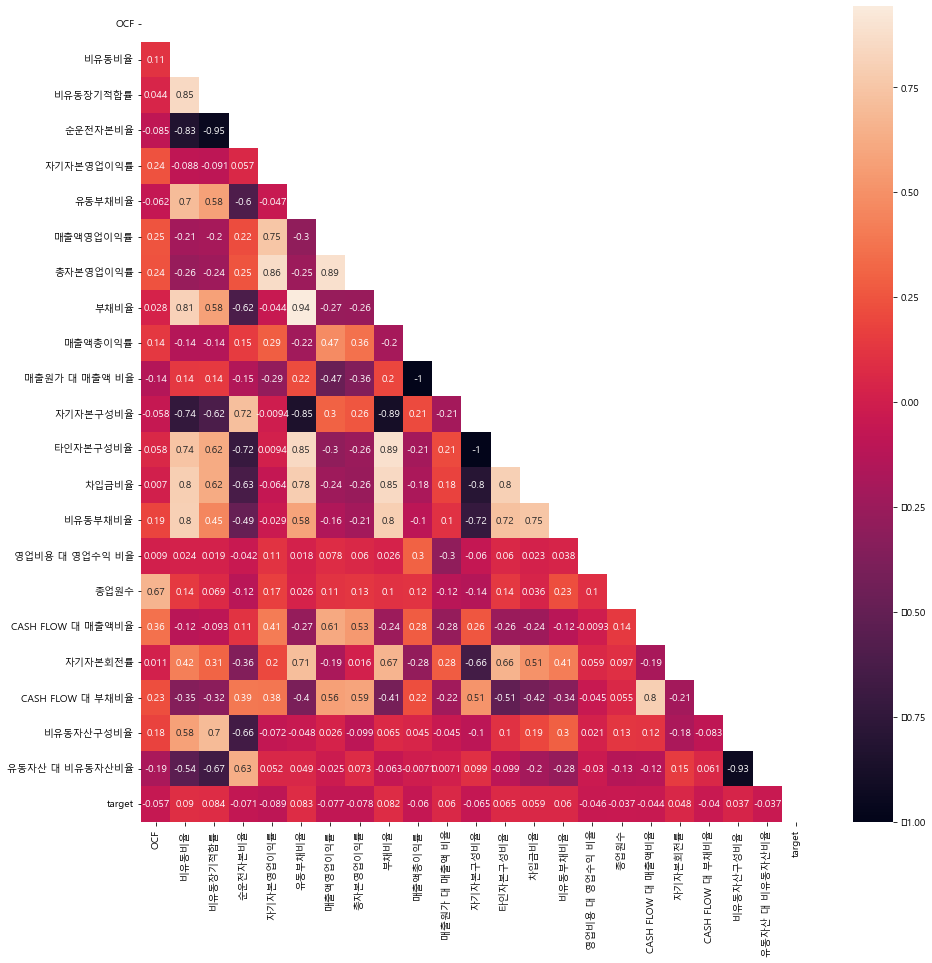

In [171]:
plt.figure(figsize=(15, 15))
mask = np.zeros_like(kospi_all_p.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(kospi_all_p.corr(), annot=True, mask=mask)

##### 코스피-부정-t_test

In [172]:
p_list_M1_wins = t_test(p_col, p_list_M1_wins_H0, p_list_M1_wins_H1, kospi_M1_good_wins, kospi_M1_bad_wins)
p_list_M1_wins

,내용,p_value
0,OCF,0.00015
12,비유동비율,0.00243
13,비유동장기적합률,0.00569
7,유동자산 대 비유동자산비율,0.01065
21,유동부채비율,0.01819
20,부채비율,0.02186
25,순운전자본비율,0.02669
48,자기자본영업이익률,0.02725
31,CASH FLOW 대 매출액비율,0.03151
46,매출액영업이익률,0.03782


In [173]:
p_M1_col = p_list_M1_wins.reset_index(drop=True)['내용']
p_M1_col[p_M1_col.index.max()+1] = 'target'
kospi_M1_p = kospi_M1_wins[p_M1_col]
kospi_M1_p

,OCF,비유동비율,비유동장기적합률,유동자산 대 비유동자산비율,유동부채비율,부채비율,순운전자본비율,자기자본영업이익률,CASH FLOW 대 매출액비율,매출액영업이익률,영업비용 대 영업수익 비율,target
0,73877.00000,291.72617,140.88992,36.42941,190.94066,298.00030,-21.27298,-5.37036,12.50487,-2.64427,-597.54475,0
1,28381.00000,291.72617,143.66234,26.68814,232.89460,411.36692,-22.65406,-4.69386,5.74803,-1.94652,-597.54475,0
2,48078.00000,291.72617,121.17777,33.57982,284.93672,411.36692,-13.08336,26.75678,8.46864,8.02511,200.49385,0
3,152722.00000,254.62239,87.34644,52.21275,96.05915,287.56775,9.51735,26.75678,20.95818,16.17682,83.78958,0
4,248312.00000,180.70584,86.71082,59.70958,80.20397,188.60454,9.59607,26.75678,20.95818,16.17682,68.19194,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3430,33913.00000,291.72617,123.85095,21.69610,151.65967,357.39237,-15.94258,12.27431,4.01283,2.51374,146.77556,0
3431,-6892.00000,291.72617,139.55220,21.69610,276.77270,411.36692,-22.65406,-11.20684,-0.82398,-1.56607,-233.36133,0
3432,-23782.00000,291.72617,141.55890,21.69610,284.93672,411.36692,-22.65406,-18.80869,-4.48289,-4.98709,-81.37568,1
3433,26890.00000,253.17644,121.67943,45.19631,159.53446,267.60285,-12.27086,12.43925,3.49254,2.50985,146.79155,0


In [174]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    kospi_M1_p.values, i) for i in range(kospi_M1_p.shape[1])]
vif["features"] = kospi_M1_p.columns
vif.sort_values('VIF Factor', ascending=False)

,VIF Factor,features
1,76.73926,비유동비율
5,66.52622,부채비율
2,46.14206,비유동장기적합률
4,44.11517,유동부채비율
3,14.92736,유동자산 대 비유동자산비율
6,8.46573,순운전자본비율
9,6.07430,매출액영업이익률
7,4.86273,자기자본영업이익률
8,2.89169,CASH FLOW 대 매출액비율
0,1.57402,OCF


<AxesSubplot:>

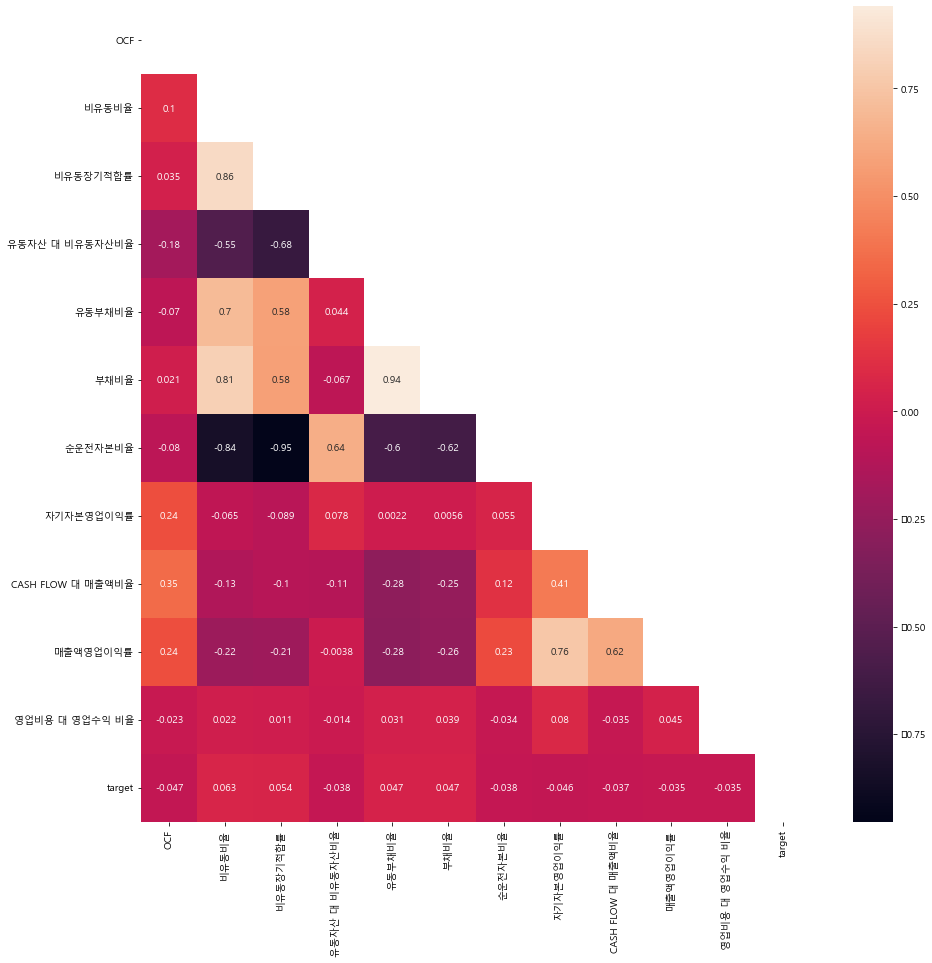

In [175]:
plt.figure(figsize=(15, 15))
mask = np.zeros_like(kospi_M1_p.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(kospi_M1_p.corr(), annot=True, mask=mask)

##### 코스피-정상-t_test

In [176]:
p_list_M0_wins = t_test(p_col, p_list_M0_wins_H0, p_list_M0_wins_H1, kospi_M0_good_wins, kospi_M0_bad_wins, p_value=0.1)
p_list_M0_wins

,내용,p_value
6,매출액총이익률,0.00017
49,매출원가 대 매출액 비율,0.00017
0,OCF,0.00700
21,유동부채비율,0.03670
50,영업비용 대 영업수익 비율,0.03683
18,재고자산 대 순운전자본비율,0.04632
40,매출채권회전기간,0.05454
20,부채비율,0.05876
25,순운전자본비율,0.07087
35,매입채무회전기간,0.07675


In [177]:
p_M0_col = p_list_M0_wins.reset_index(drop=True)['내용']
p_M0_col[p_M0_col.index.max()+1] = 'target'
kospi_M0_p = kospi_M0_wins[p_M0_col]
kospi_M0_p

,매출액총이익률,매출원가 대 매출액 비율,OCF,유동부채비율,영업비용 대 영업수익 비율,재고자산 대 순운전자본비율,매출채권회전기간,부채비율,순운전자본비율,매입채무회전기간,자기자본영업이익률,타인자본구성비율,자기자본구성비율,비유동장기적합률,target
0,7.49451,92.50549,-23782.00000,142.71648,261.07457,-128.54238,277.92410,283.85495,-2.64405,223.38183,3.08444,73.94849,26.05151,104.20891,1
1,12.19961,87.80039,57311.00000,40.98950,137.56856,61.17242,191.48091,57.42548,22.10256,177.55744,6.50171,36.47788,63.52212,70.11657,0
2,12.50768,87.49239,94174.00000,41.42087,132.51256,62.04395,194.74479,56.37593,23.33629,180.62588,6.16998,36.05154,63.94846,68.25512,0
3,11.09597,88.90403,95279.00000,35.23455,162.95855,54.90358,186.92162,50.39287,25.35970,173.35593,4.83061,33.50749,66.49251,66.88108,0
4,17.44849,82.55151,120263.00000,28.36490,74.20481,38.01582,175.75142,41.85466,32.59210,142.67854,10.56296,29.50531,70.49469,59.26210,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,2.99637,97.00363,47005.00000,233.16226,249.82613,238.79353,120.54681,249.73646,7.93728,111.51854,7.04054,71.40704,28.59296,76.18722,0
374,2.59426,97.40574,77567.00000,171.18087,460.28420,101.12594,104.23491,189.06109,12.11153,90.18495,3.69391,65.40520,34.59474,70.30072,0
375,2.59426,97.40574,-23782.00000,171.81097,222.72540,93.13438,97.59819,188.84520,14.89977,80.04725,5.83309,65.37941,34.62064,63.22677,0
376,2.59426,97.40574,27963.00000,284.93672,368.52720,324.74230,107.63303,367.12450,3.23246,97.71592,7.02823,78.59243,21.40757,88.66236,0


In [178]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    kospi_M0_p.values, i) for i in range(kospi_M0_p.shape[1])]
vif["features"] = kospi_M0_p.columns
vif

,VIF Factor,features
0,1558194744.04030,매출액총이익률
1,17289385421.22820,매출원가 대 매출액 비율
2,1.82263,OCF
3,31.55871,유동부채비율
4,1.69439,영업비용 대 영업수익 비율
5,1.28936,재고자산 대 순운전자본비율
6,10.00889,매출채권회전기간
7,39.35728,부채비율
8,19.07069,순운전자본비율
9,11.60019,매입채무회전기간


<AxesSubplot:>

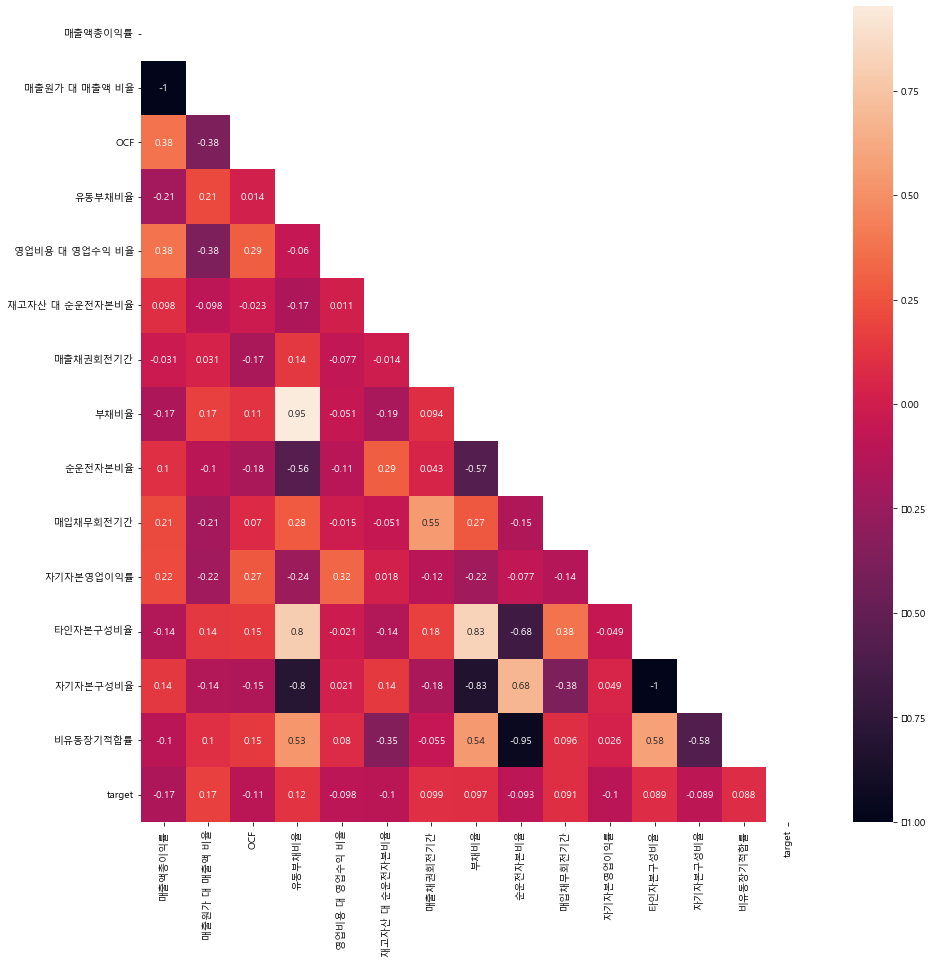

In [179]:
plt.figure(figsize=(15, 15))
mask = np.zeros_like(kospi_M0_p.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(kospi_M0_p.corr(), annot=True, mask=mask)

##### 코스닥-t_test

In [180]:
d_list_all_wins = t_test(d_col, d_list_all_wins_H0, d_list_all_wins_H1, kosdaq_all_good_wins, kosdaq_all_bad_wins, p_value=0.05)
d_list_all_wins

,내용,p_value
45,자기자본영업이익률,0.00008
44,총자본영업이익률,0.00030
27,CASH FLOW 대 부채비율,0.00031
29,CASH FLOW 대 매출액비율,0.00039
43,매출액영업이익률,0.00286
33,유동자산회전률,0.00512
0,OCF,0.01031
30,총자본회전률,0.01891
34,당좌자산회전률,0.02119
4,매출액증가율,0.02479


In [181]:
d_all_col = d_list_all_wins.reset_index(drop=True)['내용']
d_all_col[d_all_col.index.max()+1] = 'target'
kosdaq_all_p = kosdaq_all_wins[d_all_col]
kosdaq_all_p

,자기자본영업이익률,총자본영업이익률,CASH FLOW 대 부채비율,CASH FLOW 대 매출액비율,매출액영업이익률,유동자산회전률,OCF,총자본회전률,당좌자산회전률,매출액증가율,매입채무회전기간,감가상각비 대 총비용비율,target
0,-13.31392,-7.36499,-6.16452,-9.67702,-25.87512,26.02882,-1573.00000,28.46361,28.64216,-8.43285,175.14611,6.26704,0
1,1.61438,1.41470,-36.74089,-19.30693,3.87707,23.91261,-3939.00000,36.48883,26.24220,25.51215,175.98789,5.10559,0
2,0.90199,0.76118,7.99691,3.18639,1.94260,34.20938,725.00000,39.18337,39.93226,11.52338,199.83321,6.12959,0
3,-5.49490,-4.54956,24.77894,8.91206,-9.51113,49.55198,2410.00000,47.83401,61.17546,18.85026,211.93810,5.98419,0
4,1.71203,1.55974,33.64060,10.07279,5.25023,31.38685,3321.00000,29.70806,35.37781,21.92146,195.55232,6.30081,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5583,1.75619,1.68055,103.05430,2.20731,0.60138,192.70373,4265.00000,179.63861,285.70452,-22.26156,40.95316,0.66229,0
5584,0.67715,0.59190,45.83291,2.90378,0.29786,192.70373,4504.00000,179.63861,285.70452,-19.72550,40.95316,0.66229,0
5585,1.39351,1.21814,11.20482,0.77586,0.67018,192.70373,1116.00000,179.63861,285.70452,-7.26397,40.95316,0.66229,0
5586,1.07664,0.93978,15.33766,1.00182,0.48291,192.70373,1558.00000,179.63861,285.70452,8.11730,40.95316,0.66229,0


In [182]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    kosdaq_all_p.values, i) for i in range(kosdaq_all_p.shape[1])]
vif["features"] = kosdaq_all_p.columns
vif

,VIF Factor,features
0,7.39746,자기자본영업이익률
1,16.09275,총자본영업이익률
2,4.59047,CASH FLOW 대 부채비율
3,5.21180,CASH FLOW 대 매출액비율
4,7.62951,매출액영업이익률
5,36.74700,유동자산회전률
6,2.28932,OCF
7,12.89134,총자본회전률
8,25.62875,당좌자산회전률
9,1.29745,매출액증가율


<AxesSubplot:>

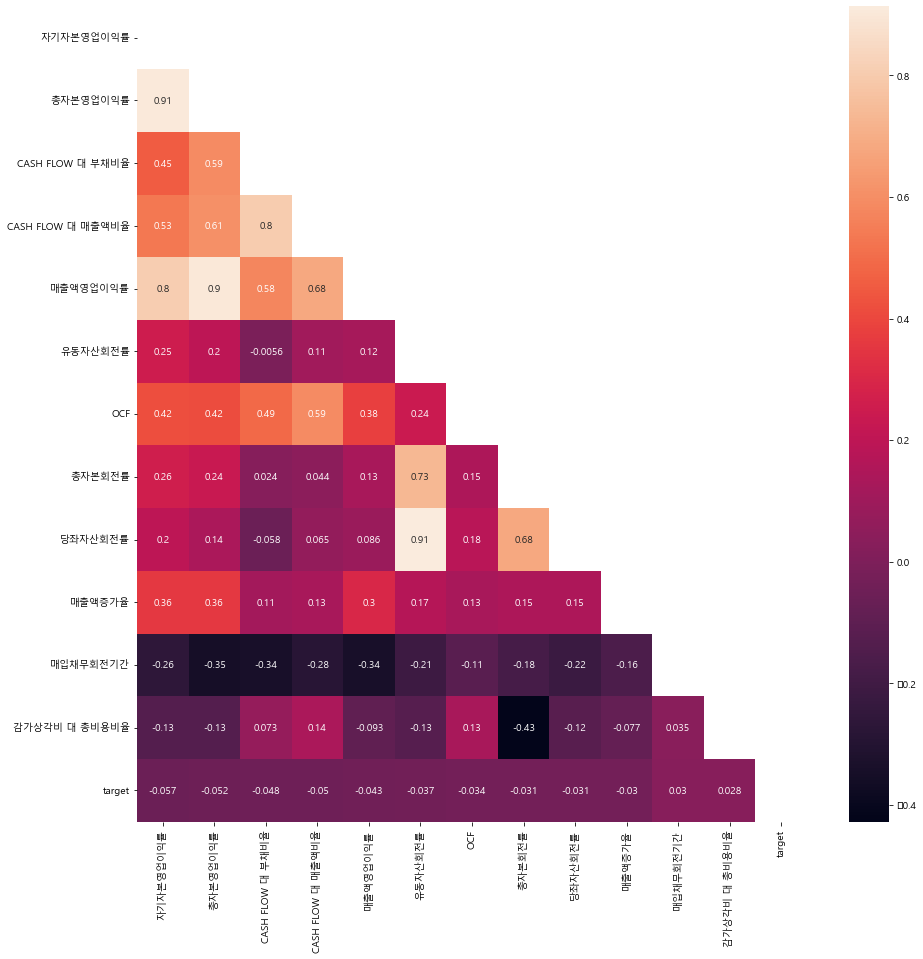

In [183]:
plt.figure(figsize=(15, 15))
mask = np.zeros_like(kosdaq_all_p.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(kosdaq_all_p.corr(), annot=True, mask=mask)

##### 코스닥-부정-t_test

In [184]:
d_list_M1_wins = t_test(d_col, d_list_M1_wins_H0, d_list_M1_wins_H1, kosdaq_M1_good_wins, kosdaq_M1_bad_wins, p_value=0.05)
d_list_M1_wins

,내용,p_value
33,유동자산회전률,0.00133
29,CASH FLOW 대 매출액비율,0.00300
34,당좌자산회전률,0.00385
27,CASH FLOW 대 부채비율,0.00487
30,총자본회전률,0.00684
0,OCF,0.01164
45,자기자본영업이익률,0.01437
6,유동자산 대 비유동자산비율,0.02693
1,총자본증가율,0.02876
48,감가상각비 대 총비용비율,0.04078


In [185]:
d_M1_col = d_list_M1_wins.reset_index(drop=True)['내용']
d_M1_col[d_M1_col.index.max()+1] = 'target'
kosdaq_M1_p = kosdaq_M1_wins[d_M1_col]
kosdaq_M1_p

,유동자산회전률,CASH FLOW 대 매출액비율,당좌자산회전률,CASH FLOW 대 부채비율,총자본회전률,OCF,자기자본영업이익률,유동자산 대 비유동자산비율,총자본증가율,감가상각비 대 총비용비율,당좌자산구성비율,target
0,26.02882,-9.67702,28.64216,-6.16452,28.46361,-1573.00000,-13.31392,471.13711,71.99711,6.26704,77.19941,0
1,23.91261,-19.30693,26.24220,-36.74089,36.48883,-3939.00000,1.61438,215.83912,-2.09253,5.10559,60.07726,0
2,34.20938,3.18639,39.93226,7.99691,39.18337,725.00000,0.90199,95.07508,3.85420,6.12959,40.27692,0
3,49.55198,8.91206,61.17546,24.77894,47.83401,2410.00000,-5.49490,86.81802,-2.64345,5.98419,36.82097,0
4,31.38685,10.07279,35.37781,33.64060,29.70806,3321.00000,1.71203,244.57278,71.99711,6.30081,65.21716,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5208,192.70373,2.20731,285.70452,103.05430,179.63861,4265.00000,1.75619,31.08364,-2.83442,0.66229,20.59181,0
5209,192.70373,2.90378,285.70452,45.83291,179.63861,4504.00000,0.67715,27.44741,12.88615,0.66229,15.53796,0
5210,192.70373,0.77586,285.70452,11.20482,179.63861,1116.00000,1.39351,27.44741,1.38750,0.66229,15.51108,0
5211,192.70373,1.00182,285.70452,15.33766,179.63861,1558.00000,1.07664,27.44741,0.97931,0.66229,16.42307,0


In [186]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    kosdaq_M1_p.values, i) for i in range(kosdaq_M1_p.shape[1])]
vif["features"] = kosdaq_M1_p.columns
vif

,VIF Factor,features
0,48.56754,유동자산회전률
1,4.37340,CASH FLOW 대 매출액비율
2,37.61759,당좌자산회전률
3,4.20163,CASH FLOW 대 부채비율
4,25.83931,총자본회전률
5,2.23176,OCF
6,2.17816,자기자본영업이익률
7,9.21529,유동자산 대 비유동자산비율
8,1.71344,총자본증가율
9,3.49064,감가상각비 대 총비용비율


<AxesSubplot:>

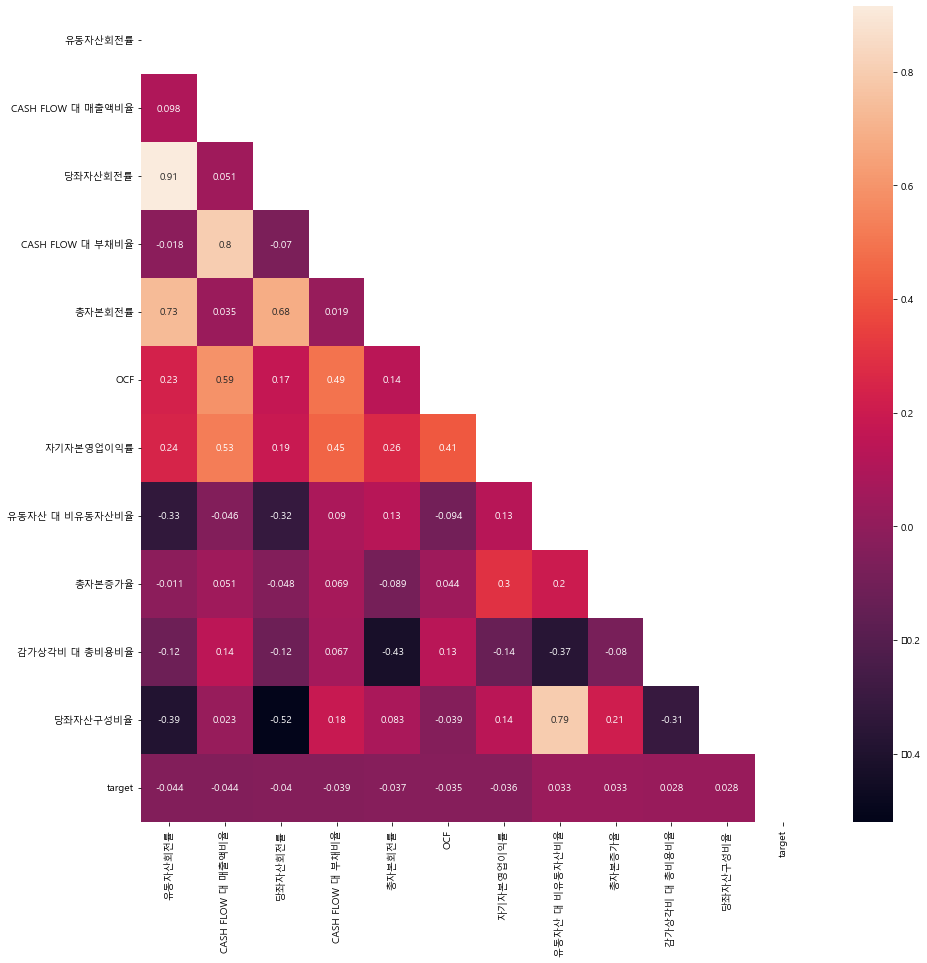

In [187]:
plt.figure(figsize=(15, 15))
mask = np.zeros_like(kosdaq_M1_p.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(kosdaq_M1_p.corr(), annot=True, mask=mask)

##### 코스닥-정상-t_test

In [188]:
d_list_M0_wins = t_test(d_col, d_list_M0_wins_H0, d_list_M0_wins_H1, kosdaq_M0_good_wins, kosdaq_M0_bad_wins, p_value=0.3)
d_list_M0_wins

,내용,p_value
42,종업원수,0.03266
34,당좌자산회전률,0.11914
41,1회전기간,0.12386
12,비유동장기적합률,0.18762
33,유동자산회전률,0.18878
20,단기차입금 대 총차입금비율,0.20107
46,매출원가 대 매출액 비율,0.20213
5,매출액총이익률,0.20214
43,매출액영업이익률,0.20653
44,총자본영업이익률,0.21960


In [189]:
d_M0_col = d_list_M0_wins.reset_index(drop=True)['내용']
d_M0_col[d_M0_col.index.max()+1] = 'target'
kosdaq_M0_p = kosdaq_M0_wins[d_M0_col]
kosdaq_M0_p

,종업원수,당좌자산회전률,1회전기간,비유동장기적합률,유동자산회전률,단기차입금 대 총차입금비율,매출원가 대 매출액 비율,매출액총이익률,매출액영업이익률,총자본영업이익률,재고자산 대 순운전자본비율,유동부채비율,target
0,157.00000,98.34409,152.39035,80.91703,87.53640,83.27966,70.66007,29.33993,-5.31113,-4.48692,44.34010,81.11137,1
1,194.00000,171.11142,270.77582,52.54282,82.85717,98.22107,87.33167,12.66716,1.54941,1.47272,85.31443,32.76590,1
2,58.00000,164.28898,193.67451,147.23114,100.05569,38.41015,79.41831,20.58169,-17.97940,-7.14286,-26.66331,239.88083,0
3,31.00000,29.65552,454.15435,65.68303,26.91919,100.00000,52.66598,47.33402,17.17962,6.47087,43.45731,121.43291,0
4,11.00000,167.47955,144.13717,113.18959,121.49567,49.00592,84.45691,15.54309,7.78047,6.18967,-93.72502,79.15552,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,539.00000,142.75597,29.96156,93.40912,141.79243,38.10379,91.17995,8.82005,4.07725,5.60115,9.87888,94.43842,1
371,94.00000,101.32478,151.72934,81.41663,78.98534,68.67189,77.40866,22.59134,5.32189,5.52159,157.30193,132.30261,1
372,153.00000,63.86315,372.07005,64.89236,47.38664,73.19035,79.45558,20.54442,-13.80032,-8.74200,81.11957,84.62599,0
373,98.00000,96.73158,193.31439,147.23114,72.58938,88.78345,95.63671,4.36329,-23.69959,-15.98007,-64.04329,239.88083,0


In [190]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    kosdaq_M0_p.values, i) for i in range(kosdaq_M0_p.shape[1])]
vif["features"] = kosdaq_M0_p.columns
vif

,VIF Factor,features
0,2.77219,종업원수
1,24.88518,당좌자산회전률
2,3.87632,1회전기간
3,11.35189,비유동장기적합률
4,34.85925,유동자산회전률
5,4.27897,단기차입금 대 총차입금비율
6,12.45552,매출원가 대 매출액 비율
7,2.73471,매출액총이익률
8,6.31655,매출액영업이익률
9,5.62760,총자본영업이익률


<AxesSubplot:>

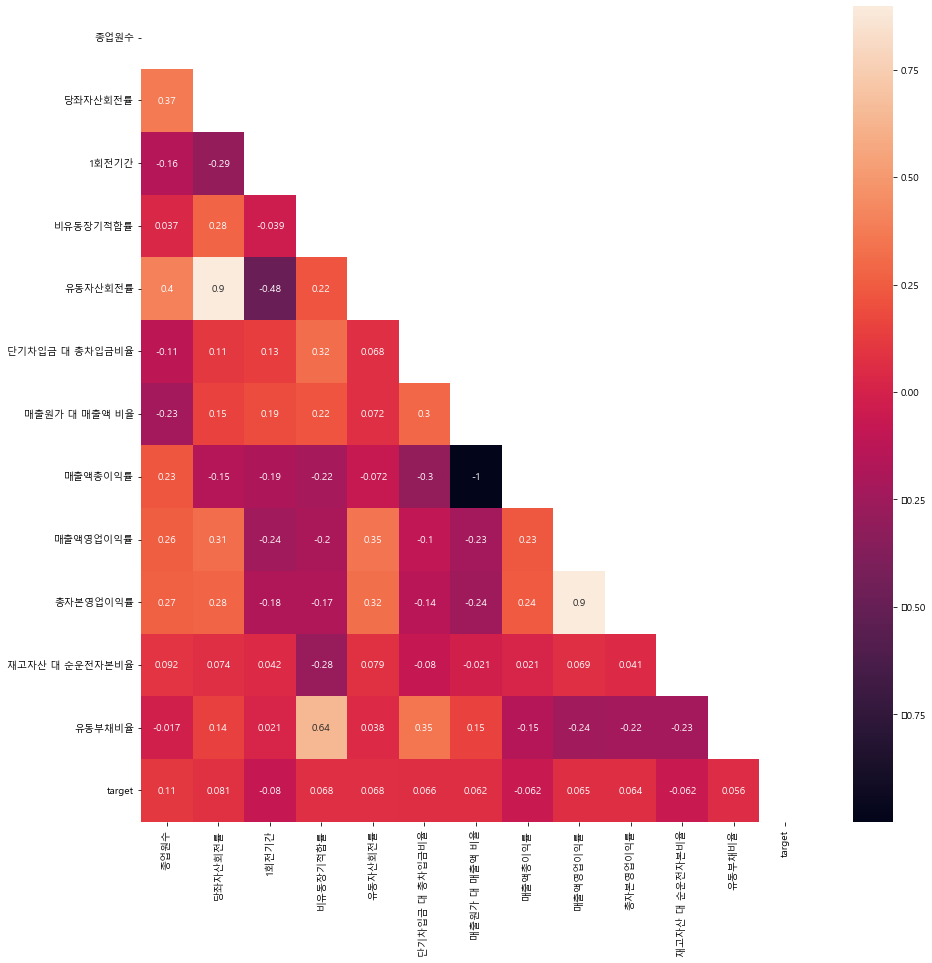

In [191]:
plt.figure(figsize=(15, 15))
mask = np.zeros_like(kosdaq_M0_p.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(kosdaq_M0_p.corr(), annot=True, mask=mask)

#### Feature Imfortance

##### 함수

XGBoost

In [192]:
def XGBoost(df):
    
    features = df.drop(['target'], axis=1)
    target = df[['target']]
    features, target = SMOTE(random_state=121).fit_resample(features, target)
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2)

    scaler = RobustScaler()
    X_train_scaler = scaler.fit_transform(X_train)
    X_test_scaler = scaler.transform(X_test)

    xgb = XGBClassifier(booster='gbtree', random_state=42)
    xgb.fit(X_train_scaler, y_train)

    pred = xgb.predict(X_test_scaler)
    report = classification_report(y_test, pred)
    # print(f1_score(y_test, pred))
    # print(report)
    
    # feature importance
    feature_importance = pd.Series(xgb.feature_importances_, index=X_train.columns)
    feature_importance.sort_values(ascending=False, inplace=True)

    plt.figure(figsize=(10,10))
    sns.barplot(feature_importance.values, feature_importance.index)
    plt.title('XGBoost Feature Importance\n', fontsize=15)
    return pd.DataFrame(feature_importance, columns=['FI'])
    # return feature_importance.index[:8]

Random Forest

In [193]:
def RandomForest(df):

    features = df.drop(['target'], axis=1)
    target = df[['target']]
    features, target = SMOTE(random_state=121).fit_resample(features, target)
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2)

    scaler = RobustScaler()
    X_train_scaler = scaler.fit_transform(X_train)
    X_test_scaler = scaler.transform(X_test)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_scaler, y_train)

    pred = rf.predict(X_test_scaler)
    report = classification_report(y_test, pred)
    # print(f1_score(y_test, pred))
    # print(report)

    feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
    feature_importance.sort_values(ascending=False, inplace=True)

    plt.figure(figsize=(10,10))
    sns.barplot(feature_importance.values, feature_importance.index)
    plt.title('RandomForest Feature Importance\n', fontsize=15)
    return pd.DataFrame(feature_importance, columns=['FI'])
    # return feature_importance.index[:8]

DecisionTree

In [194]:
def DecisionTree(df):

    features = df.drop(['target'], axis=1)
    target = df[['target']]
    features, target = SMOTE(random_state=121).fit_resample(features, target)
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2)

    scaler = RobustScaler()
    X_train_scaler = scaler.fit_transform(X_train)
    X_test_scaler = scaler.transform(X_test)

    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train_scaler, y_train)

    pred = dt.predict(X_test_scaler)
    report = classification_report(y_test, pred)
    # print(f1_score(y_test, pred))
    # print(report)

    feature_importance = pd.Series(dt.feature_importances_, index=X_train.columns)
    feature_importance.sort_values(ascending=False, inplace=True)

    plt.figure(figsize=(10,10))
    sns.barplot(feature_importance.values, feature_importance.index)
    plt.title('DecisionTree Feature Importance\n', fontsize=15)
    return pd.DataFrame(feature_importance, columns=['FI'])
    # return feature_importance.index[:8]

AdaBoost

In [195]:
def AdaBoost(df):

    features = df.drop(['target'], axis=1)
    target = df[['target']]
    features, target = SMOTE(random_state=121).fit_resample(features, target)
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2)

    scaler = RobustScaler()
    X_train_scaler = scaler.fit_transform(X_train)
    X_test_scaler = scaler.transform(X_test)

    ada = AdaBoostClassifier(random_state=42)
    ada.fit(X_train_scaler, y_train)

    pred = ada.predict(X_test_scaler)
    report = classification_report(y_test, pred)
    # print(f1_score(y_test, pred))
    # print(report)

    feature_importance = pd.Series(ada.feature_importances_, index=X_train.columns)
    feature_importance.sort_values(ascending=False, inplace=True)
    plt.figure(figsize=(10,10))
    sns.barplot(feature_importance.values, feature_importance.index)
    plt.title('AdaBoost Feature Importance\n', fontsize=15)
    return pd.DataFrame(feature_importance, columns=['FI'])
    # return feature_importance.index[:8]

##### 코스피

전체

,FI
자기자본영업이익률,0.07327
영업비용 대 영업수익 비율,0.06933
매출원가 대 매출액 비율,0.06305
자기자본구성비율,0.05782
OCF,0.05539
매출액영업이익률,0.05536
차입금비율,0.05319
부채비율,0.04931
종업원수,0.04571
비유동자산구성비율,0.04558


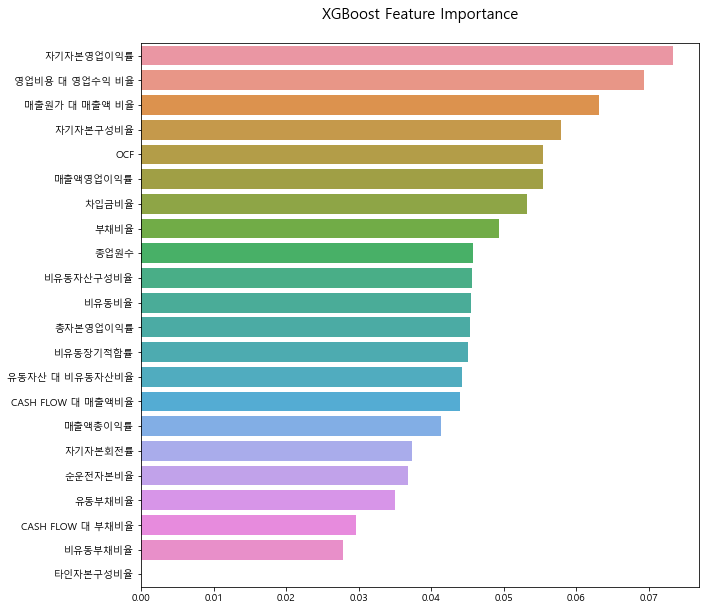

In [196]:
kospi_all_xgb = XGBoost(kospi_all_p)
kospi_all_xgb

,FI
영업비용 대 영업수익 비율,0.07589
OCF,0.06885
종업원수,0.06422
자기자본영업이익률,0.05730
차입금비율,0.05057
매출액영업이익률,0.04912
자기자본회전률,0.04861
매출원가 대 매출액 비율,0.04792
총자본영업이익률,0.04635
매출액총이익률,0.04515


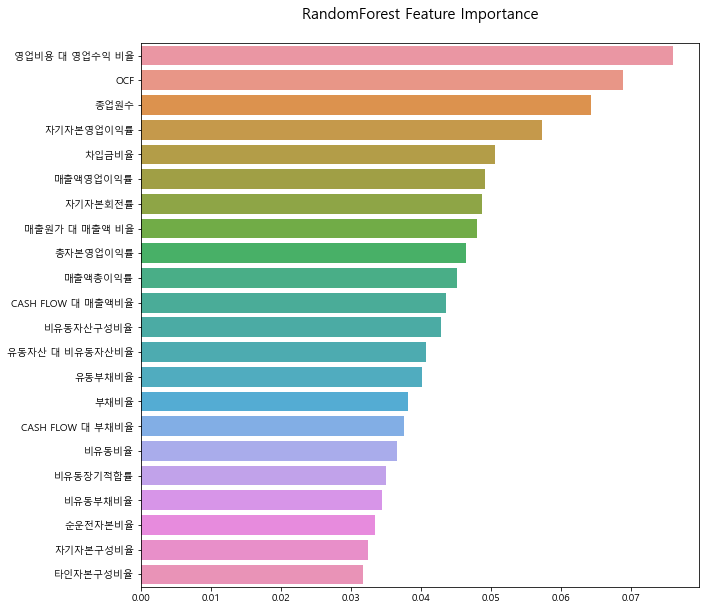

In [197]:
kospi_all_rf = RandomForest(kospi_all_p)
kospi_all_rf

,FI
OCF,0.10617
영업비용 대 영업수익 비율,0.08336
종업원수,0.08047
자기자본영업이익률,0.06975
매출액영업이익률,0.06391
매출원가 대 매출액 비율,0.06290
비유동장기적합률,0.05167
차입금비율,0.04979
자기자본회전률,0.04958
CASH FLOW 대 부채비율,0.04715


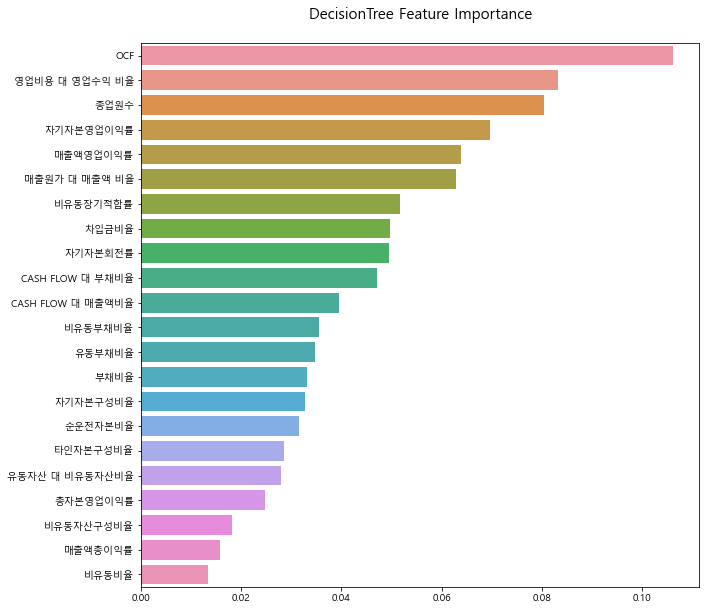

In [198]:
kospi_all_dt = DecisionTree(kospi_all_p)
kospi_all_dt

,FI
영업비용 대 영업수익 비율,0.14000
차입금비율,0.12000
자기자본영업이익률,0.10000
OCF,0.08000
CASH FLOW 대 매출액비율,0.08000
자기자본회전률,0.06000
매출액총이익률,0.06000
비유동자산구성비율,0.04000
유동부채비율,0.04000
총자본영업이익률,0.04000


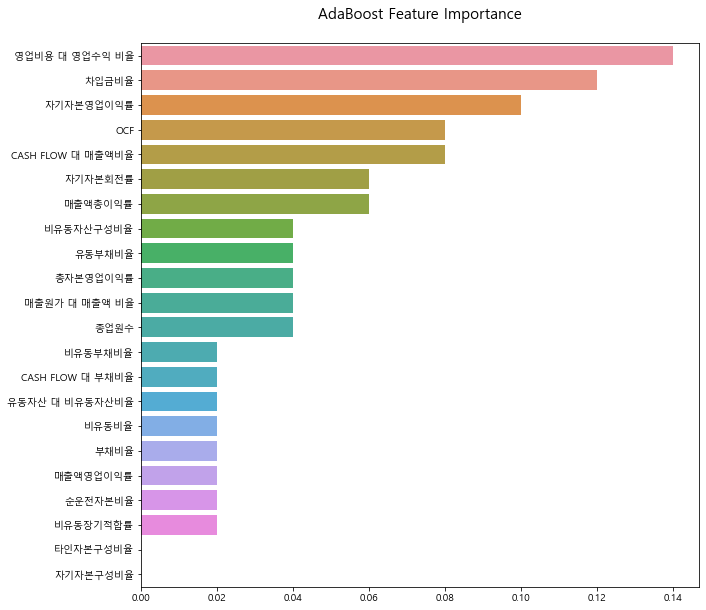

In [199]:
kospi_all_ada = AdaBoost(kospi_all_p)
kospi_all_ada

In [200]:
kospi_all_col = set(kospi_all_xgb).union(set(kospi_all_rf))
kospi_all_col = kospi_all_col.union(set(kospi_all_dt))
kospi_all_col = kospi_all_col.union(set(kospi_all_ada))
pd.DataFrame(kospi_all_col)

,0
0,FI


In [201]:
# kospi_all_col_remove = {'자기자본영업이익률', '비유동자산구성비율', '부채비율', '자기자본구성비율'}
# kospi_all_col = kospi_all_col - kospi_all_col_remove
# kospi_all_col = list(kospi_all_col)

# kospi_all_col.append('target')
# kospi_all_p = kospi_all_wins[kospi_all_col]
# kospi_all_p

코스피 부정

,FI
OCF,0.12709
영업비용 대 영업수익 비율,0.10728
자기자본영업이익률,0.10200
유동자산 대 비유동자산비율,0.09967
유동부채비율,0.09473
CASH FLOW 대 매출액비율,0.09158
부채비율,0.08452
매출액영업이익률,0.08083
비유동비율,0.07602
순운전자본비율,0.07413


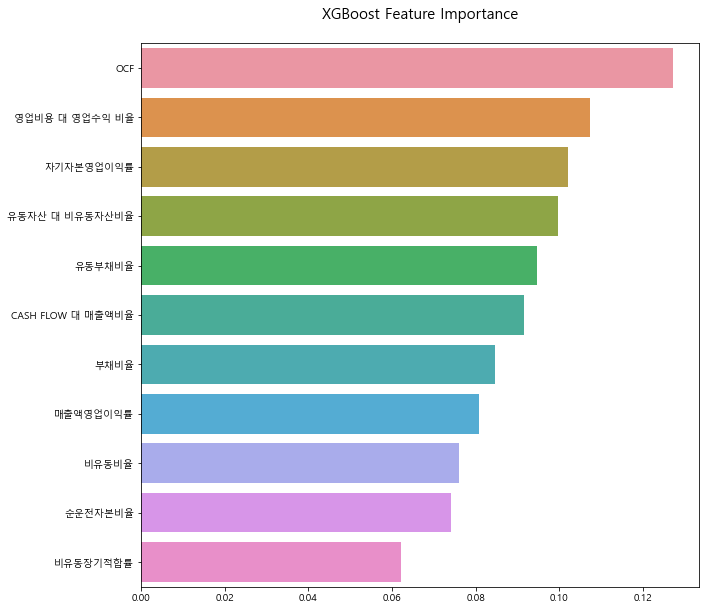

In [202]:
kospi_m1_xgb = XGBoost(kospi_M1_p)
kospi_m1_xgb

,FI
OCF,0.14654
영업비용 대 영업수익 비율,0.12247
자기자본영업이익률,0.10466
유동자산 대 비유동자산비율,0.10210
CASH FLOW 대 매출액비율,0.09622
매출액영업이익률,0.08628
비유동비율,0.07314
유동부채비율,0.07097
부채비율,0.06769
순운전자본비율,0.06549


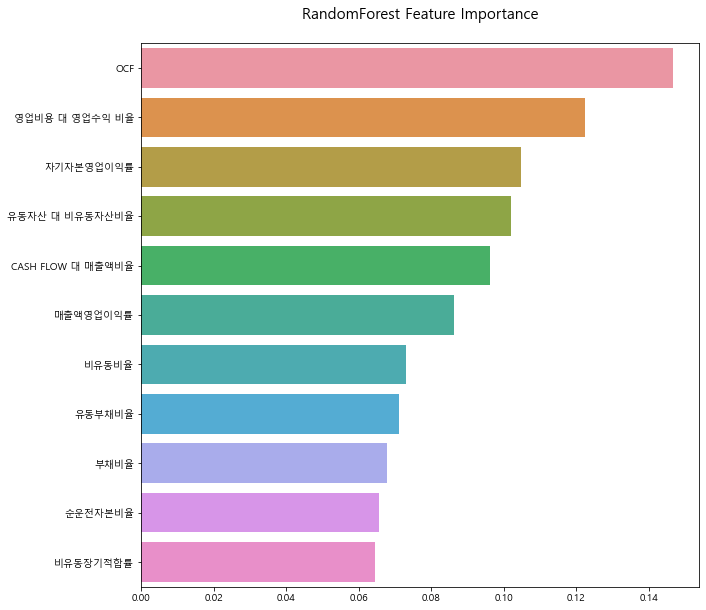

In [203]:
kospi_m1_rf = RandomForest(kospi_M1_p)
kospi_m1_rf

,FI
OCF,0.22603
영업비용 대 영업수익 비율,0.14496
CASH FLOW 대 매출액비율,0.12469
유동자산 대 비유동자산비율,0.09922
매출액영업이익률,0.08837
자기자본영업이익률,0.08037
부채비율,0.07600
유동부채비율,0.05929
비유동비율,0.04324
비유동장기적합률,0.03188


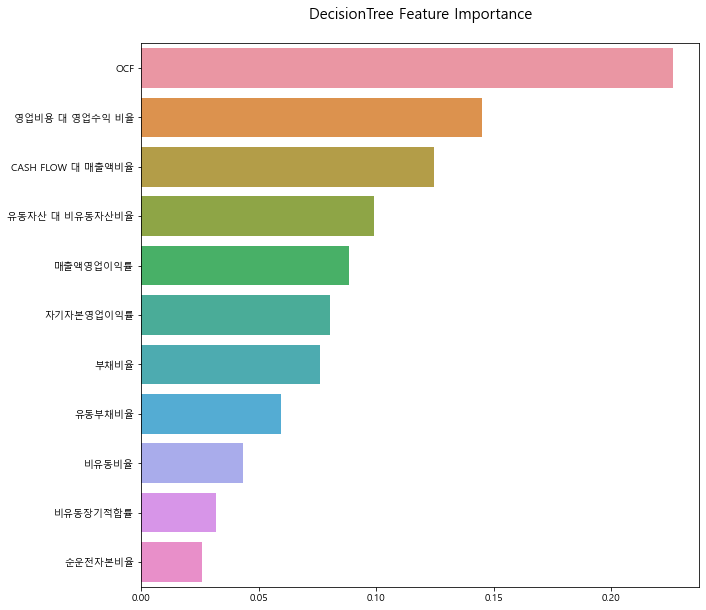

In [204]:
kospi_m1_dt = DecisionTree(kospi_M1_p)
kospi_m1_dt

,FI
OCF,0.22000
영업비용 대 영업수익 비율,0.16000
유동자산 대 비유동자산비율,0.10000
자기자본영업이익률,0.10000
비유동비율,0.08000
CASH FLOW 대 매출액비율,0.08000
비유동장기적합률,0.06000
유동부채비율,0.06000
순운전자본비율,0.06000
부채비율,0.04000


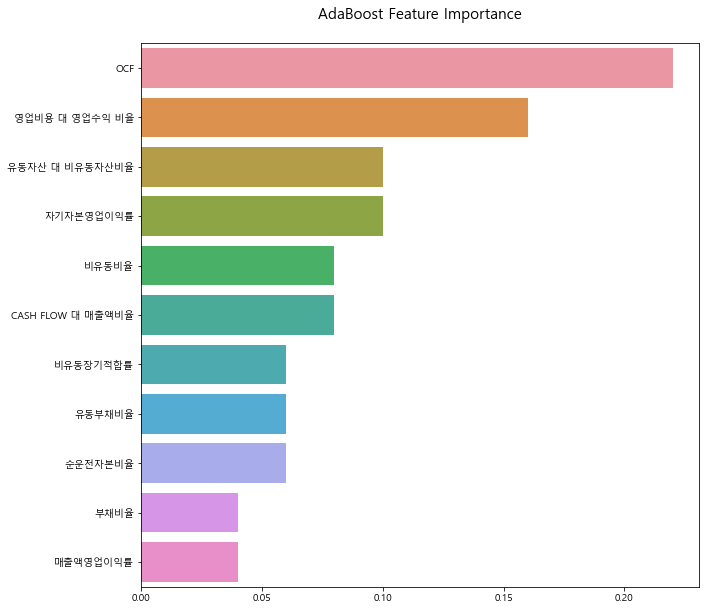

In [205]:
kospi_m1_ada = AdaBoost(kospi_M1_p)
kospi_m1_ada

In [206]:
kospi_m1_col = set(kospi_m1_xgb).union(set(kospi_m1_rf))
kospi_m1_col = kospi_m1_col.union(set(kospi_m1_dt))
kospi_m1_col = kospi_m1_col.union(set(kospi_m1_ada))
pd.DataFrame(kospi_m1_col)

,0
0,FI


In [207]:
# kospi_m1_col_remove = {'자기자본영업이익률', '비유동비율', '부채비율'}
# kospi_m1_col = kospi_m1_col - kospi_m1_col_remove
# kospi_m1_col = list(kospi_m1_col)

# kospi_m1_col.append('target')
# kospi_M1_p = kospi_M1_wins[kospi_m1_col]
# kospi_M1_p

코스피 정상

,FI
타인자본구성비율,0.11633
매출액총이익률,0.10527
매입채무회전기간,0.10386
재고자산 대 순운전자본비율,0.09791
부채비율,0.08734
순운전자본비율,0.08594
OCF,0.08207
자기자본영업이익률,0.07785
매출채권회전기간,0.07324
영업비용 대 영업수익 비율,0.07190


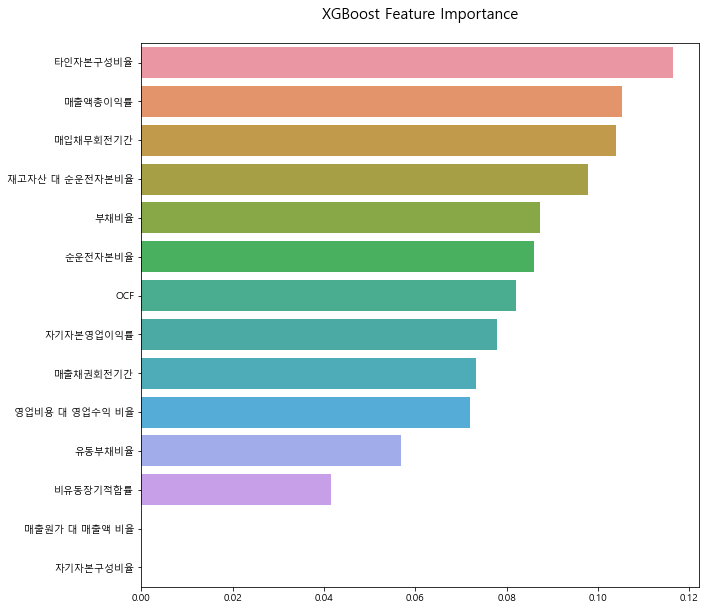

In [208]:
kospi_m0_xgb = XGBoost(kospi_M0_p)
kospi_m0_xgb

,FI
재고자산 대 순운전자본비율,0.09734
매출액총이익률,0.08790
매입채무회전기간,0.08747
영업비용 대 영업수익 비율,0.08318
매출원가 대 매출액 비율,0.08251
자기자본영업이익률,0.07874
매출채권회전기간,0.07773
OCF,0.07028
유동부채비율,0.06444
순운전자본비율,0.05822


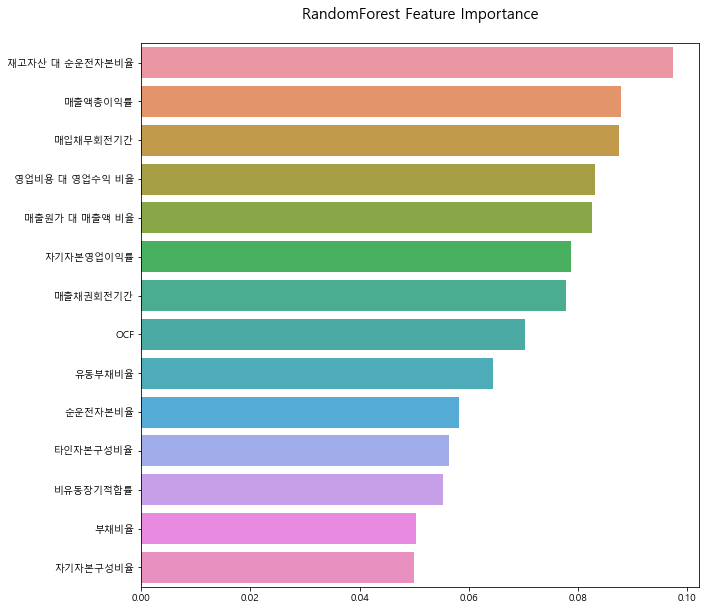

In [209]:
kospi_m0_rf = RandomForest(kospi_M0_p)
kospi_m0_rf

,FI
매입채무회전기간,0.15730
OCF,0.14035
매출액총이익률,0.11416
매출원가 대 매출액 비율,0.08877
매출채권회전기간,0.07781
자기자본영업이익률,0.07620
영업비용 대 영업수익 비율,0.07275
재고자산 대 순운전자본비율,0.07272
자기자본구성비율,0.05224
순운전자본비율,0.04588


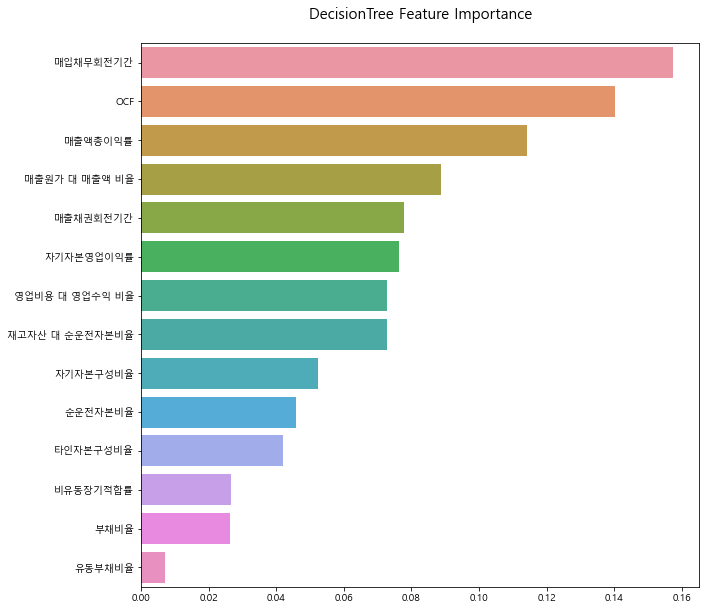

In [210]:
kospi_m0_dt = DecisionTree(kospi_M0_p)
kospi_m0_dt

,FI
자기자본영업이익률,0.18000
OCF,0.14000
영업비용 대 영업수익 비율,0.14000
재고자산 대 순운전자본비율,0.10000
순운전자본비율,0.08000
매출액총이익률,0.06000
매출원가 대 매출액 비율,0.06000
유동부채비율,0.06000
매출채권회전기간,0.06000
매입채무회전기간,0.04000


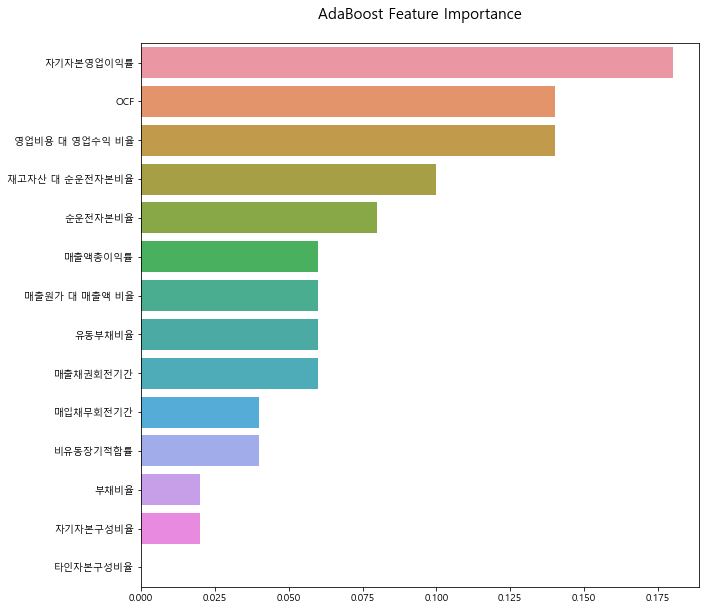

In [211]:
kospi_m0_ada = AdaBoost(kospi_M0_p)
kospi_m0_ada

In [212]:
kospi_m0_col = set(kospi_m0_xgb).union(set(kospi_m0_rf))
kospi_m0_col = kospi_m0_col.union(set(kospi_m0_dt))
kospi_m0_col = kospi_m0_col.union(set(kospi_m0_ada))
pd.DataFrame(kospi_m0_col)

,0
0,FI


In [213]:
# kospi_m0_col_remove = {'영업비용 대 영업수익 비율', '매출원가 대 매출액 비율', '타인자본구성비율', '부채비율'}
# kospi_m0_col = kospi_m0_col - kospi_m0_col_remove
# kospi_m0_col = list(kospi_m0_col)

# kospi_m0_col.append('target')
# kospi_M0_p = kospi_M0_wins[kospi_m0_col]
# kospi_M0_p

##### 코스닥

전체

,FI
OCF,0.10574
자기자본영업이익률,0.09899
CASH FLOW 대 매출액비율,0.09033
CASH FLOW 대 부채비율,0.08889
매출액영업이익률,0.08864
감가상각비 대 총비용비율,0.08663
당좌자산회전률,0.07972
매입채무회전기간,0.07723
매출액증가율,0.07686
총자본영업이익률,0.07130


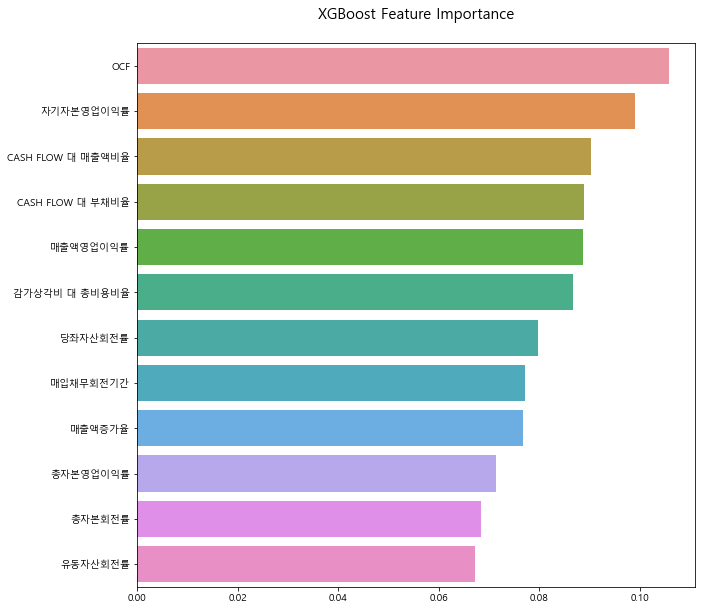

In [214]:
kosdaq_all_xgb = XGBoost(kosdaq_all_p)
kosdaq_all_xgb

,FI
OCF,0.10023
감가상각비 대 총비용비율,0.09878
CASH FLOW 대 부채비율,0.08834
매입채무회전기간,0.08788
자기자본영업이익률,0.08747
매출액증가율,0.08345
당좌자산회전률,0.07865
CASH FLOW 대 매출액비율,0.07840
매출액영업이익률,0.07811
유동자산회전률,0.07384


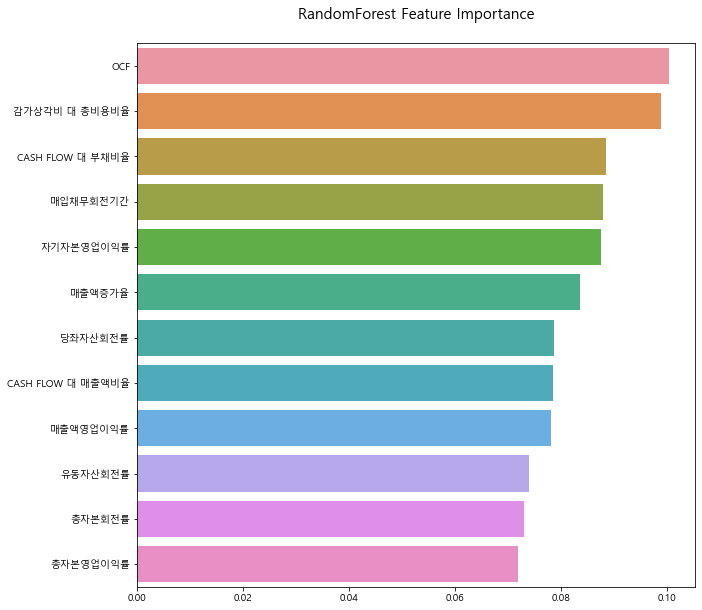

In [215]:
kosdaq_all_rf = RandomForest(kosdaq_all_p)
kosdaq_all_rf

,FI
OCF,0.11408
매입채무회전기간,0.11067
감가상각비 대 총비용비율,0.10852
매출액증가율,0.09249
CASH FLOW 대 매출액비율,0.08580
CASH FLOW 대 부채비율,0.08365
당좌자산회전률,0.08113
자기자본영업이익률,0.07920
매출액영업이익률,0.07066
유동자산회전률,0.06406


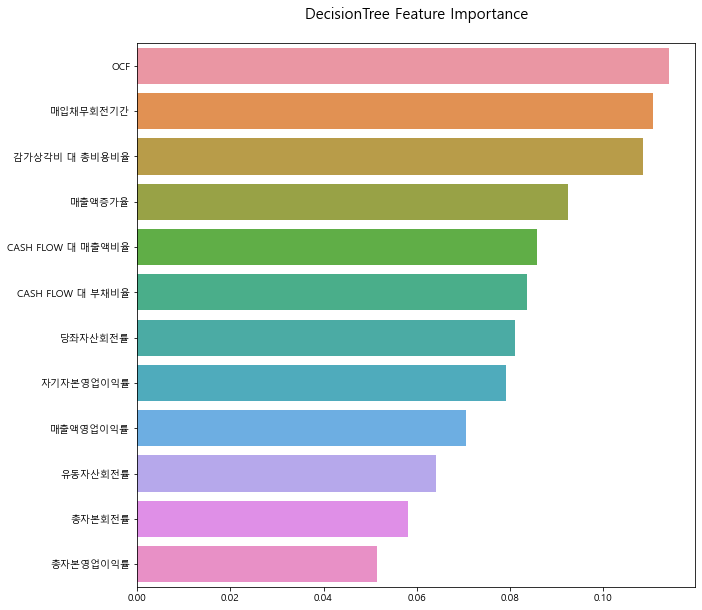

In [216]:
kosdaq_all_dt = DecisionTree(kosdaq_all_p)
kosdaq_all_dt

,FI
총자본회전률,0.14000
OCF,0.12000
매입채무회전기간,0.10000
감가상각비 대 총비용비율,0.10000
CASH FLOW 대 부채비율,0.08000
CASH FLOW 대 매출액비율,0.08000
매출액영업이익률,0.08000
당좌자산회전률,0.08000
매출액증가율,0.08000
자기자본영업이익률,0.06000


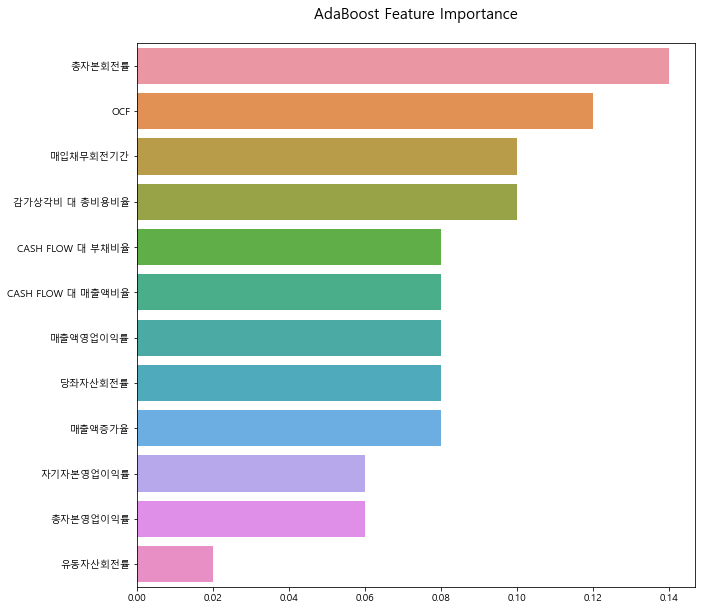

In [217]:
kosdaq_all_ada = AdaBoost(kosdaq_all_p)
kosdaq_all_ada

In [218]:
kosdaq_all_col = set(kosdaq_all_xgb).union(set(kosdaq_all_rf))
kosdaq_all_col = kosdaq_all_col.union(set(kosdaq_all_dt))
kosdaq_all_col = kosdaq_all_col.union(set(kosdaq_all_ada))
pd.DataFrame(kosdaq_all_col)

,0
0,FI


In [219]:
# kosdaq_all_col_remove = {'CASH FLOW 대 부채비율', '자기자본영업이익률'}
# kosdaq_all_col = kosdaq_all_col - kosdaq_all_col_remove
# kosdaq_all_col = list(kosdaq_all_col)

# kosdaq_all_col.append('target')
# kosdaq_all_p = kosdaq_all_wins[kosdaq_all_col]
# kosdaq_all_p

코스닥 부정

,FI
감가상각비 대 총비용비율,0.10977
OCF,0.10924
CASH FLOW 대 부채비율,0.10469
자기자본영업이익률,0.09643
총자본증가율,0.08725
당좌자산회전률,0.08633
당좌자산구성비율,0.08621
CASH FLOW 대 매출액비율,0.08512
유동자산회전률,0.08164
유동자산 대 비유동자산비율,0.07994


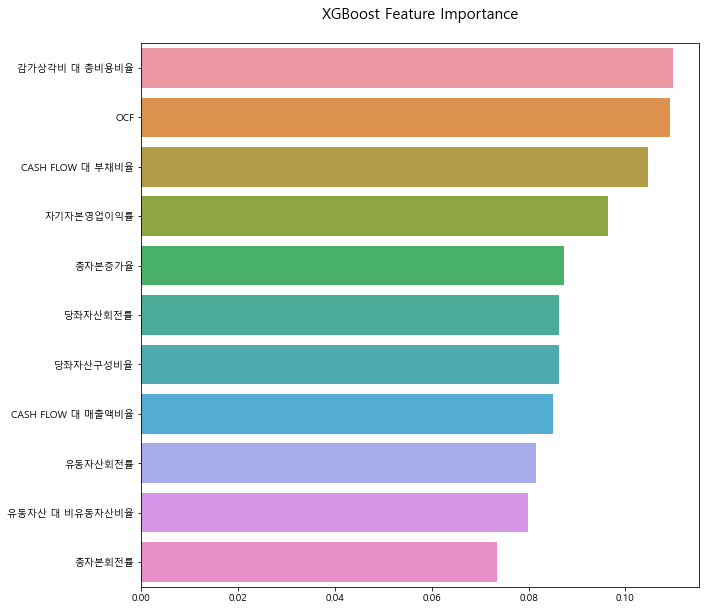

In [220]:
kosdaq_m1_xgb = XGBoost(kosdaq_M1_p)
kosdaq_m1_xgb

,FI
감가상각비 대 총비용비율,0.11322
OCF,0.10870
총자본증가율,0.09709
자기자본영업이익률,0.09651
CASH FLOW 대 부채비율,0.09455
CASH FLOW 대 매출액비율,0.08397
당좌자산구성비율,0.08341
유동자산 대 비유동자산비율,0.08167
당좌자산회전률,0.08090
유동자산회전률,0.08008


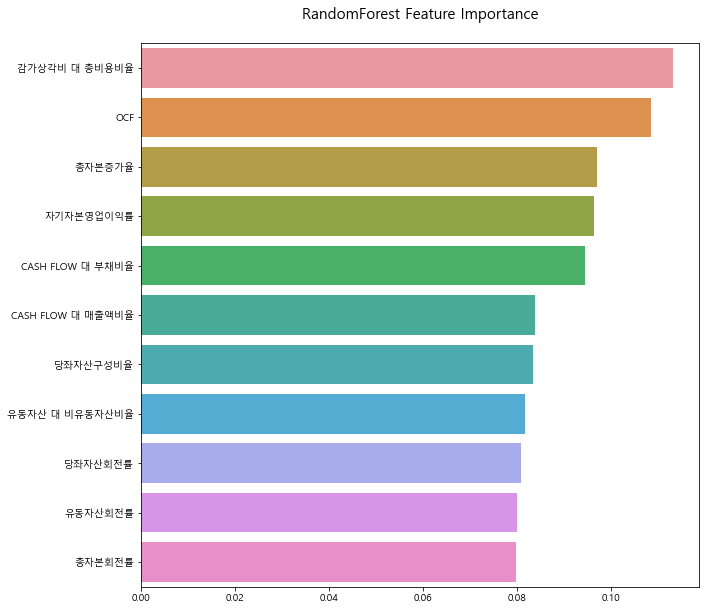

In [221]:
kosdaq_m1_rf = RandomForest(kosdaq_M1_p)
kosdaq_m1_rf

,FI
감가상각비 대 총비용비율,0.13177
OCF,0.13133
총자본증가율,0.10840
자기자본영업이익률,0.10618
CASH FLOW 대 부채비율,0.09255
당좌자산구성비율,0.08527
유동자산 대 비유동자산비율,0.07787
유동자산회전률,0.07258
총자본회전률,0.06948
당좌자산회전률,0.06784


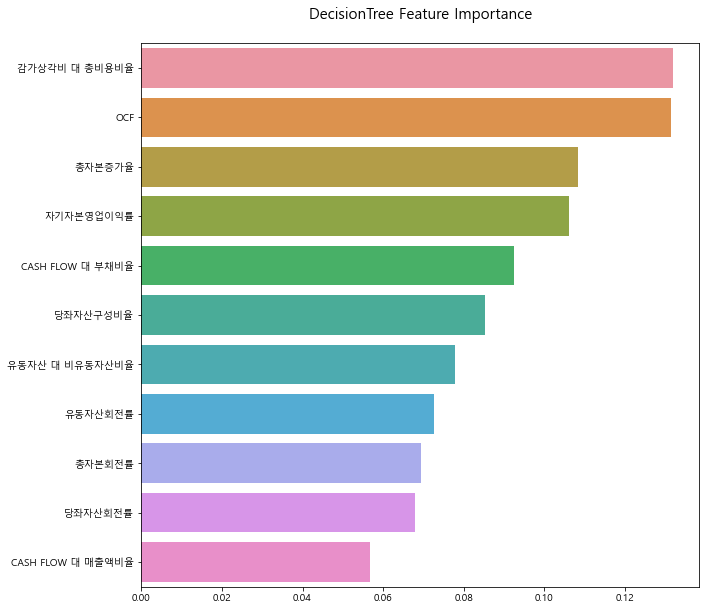

In [222]:
kosdaq_m1_dt = DecisionTree(kosdaq_M1_p)
kosdaq_m1_dt

,FI
OCF,0.20000
CASH FLOW 대 부채비율,0.10000
자기자본영업이익률,0.10000
총자본증가율,0.10000
감가상각비 대 총비용비율,0.10000
유동자산회전률,0.08000
당좌자산회전률,0.08000
총자본회전률,0.08000
유동자산 대 비유동자산비율,0.08000
당좌자산구성비율,0.06000


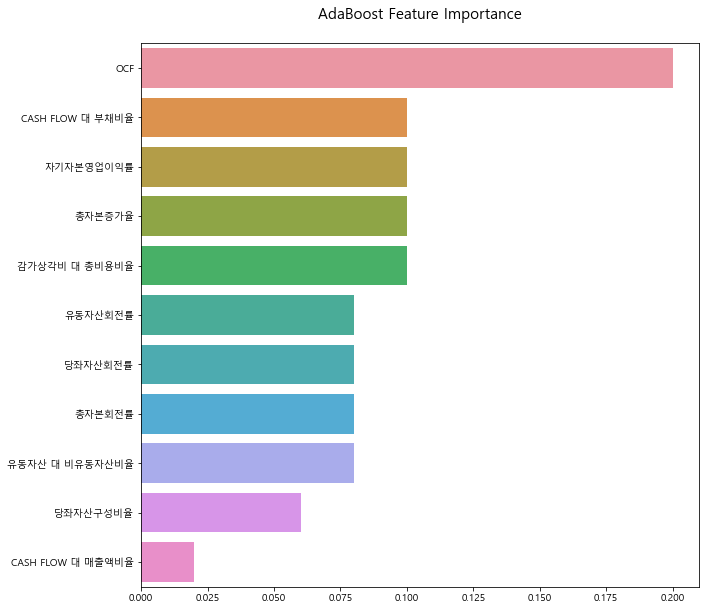

In [223]:
kosdaq_m1_ada = AdaBoost(kosdaq_M1_p)
kosdaq_m1_ada

In [224]:
kosdaq_m1_col = set(kosdaq_m1_xgb).union(set(kosdaq_m1_rf))
kosdaq_m1_col = kosdaq_m1_col.union(set(kosdaq_m1_dt))
kosdaq_m1_col = kosdaq_m1_col.union(set(kosdaq_m1_ada))
pd.DataFrame(kosdaq_m1_col)

,0
0,FI


In [225]:
# kosdaq_m1_col_remove = {'CASH FLOW 대 부채비율', '유동자산회전률', '당좌자산구성비율'}
# kosdaq_m1_col = kosdaq_m1_col - kosdaq_m1_col_remove
# kosdaq_m1_col = list(kosdaq_m1_col)

# kosdaq_m1_col.append('target')
# kosdaq_M1_p = kosdaq_M1_wins[kosdaq_m1_col]
# kosdaq_M1_p

코스닥 정상

,FI
재고자산 대 순운전자본비율,0.11797
1회전기간,0.10915
총자본영업이익률,0.10455
종업원수,0.10043
매출원가 대 매출액 비율,0.08807
당좌자산회전률,0.08803
매출액영업이익률,0.08798
유동부채비율,0.08650
단기차입금 대 총차입금비율,0.07779
비유동장기적합률,0.07045


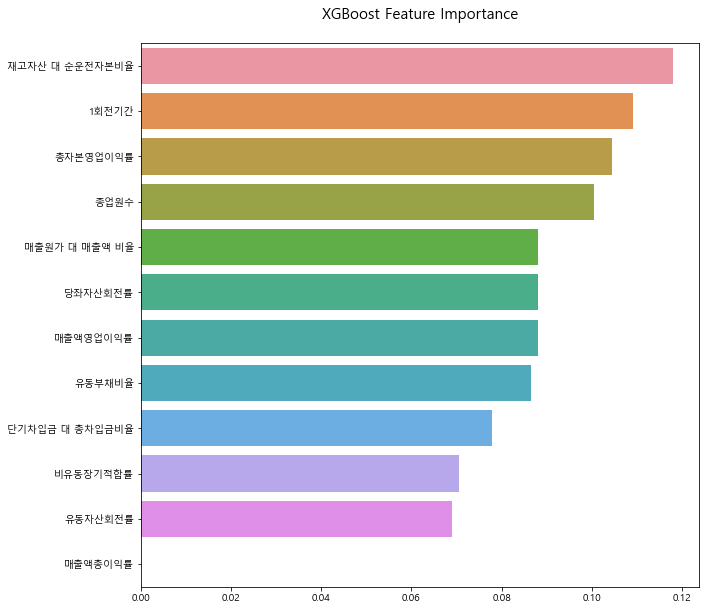

In [226]:
kosdaq_m0_xgb = XGBoost(kosdaq_M0_p)
kosdaq_m0_xgb

,FI
종업원수,0.11313
1회전기간,0.10234
재고자산 대 순운전자본비율,0.08661
유동부채비율,0.08429
유동자산회전률,0.08239
매출원가 대 매출액 비율,0.08208
총자본영업이익률,0.08017
매출액총이익률,0.07605
비유동장기적합률,0.07595
매출액영업이익률,0.07483


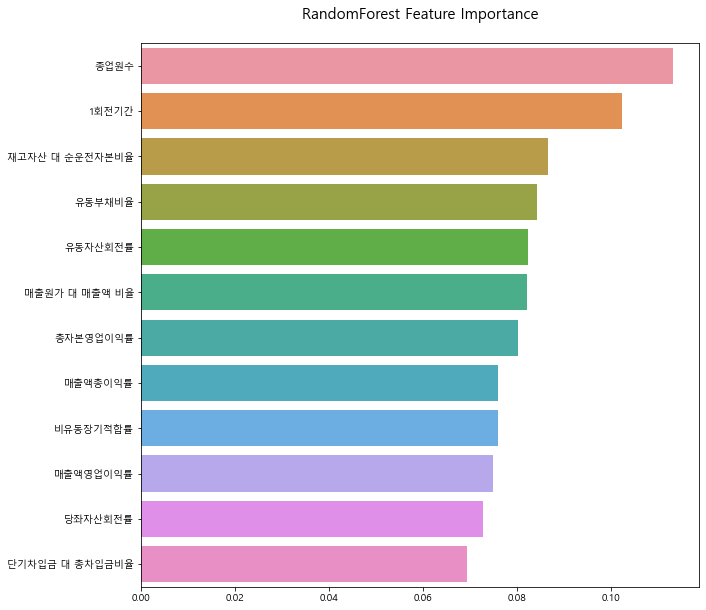

In [227]:
kosdaq_m0_rf = RandomForest(kosdaq_M0_p)
kosdaq_m0_rf

,FI
1회전기간,0.17978
총자본영업이익률,0.10631
종업원수,0.10584
재고자산 대 순운전자본비율,0.08914
비유동장기적합률,0.08702
유동부채비율,0.07388
매출원가 대 매출액 비율,0.06730
유동자산회전률,0.06181
매출액총이익률,0.06076
매출액영업이익률,0.05807


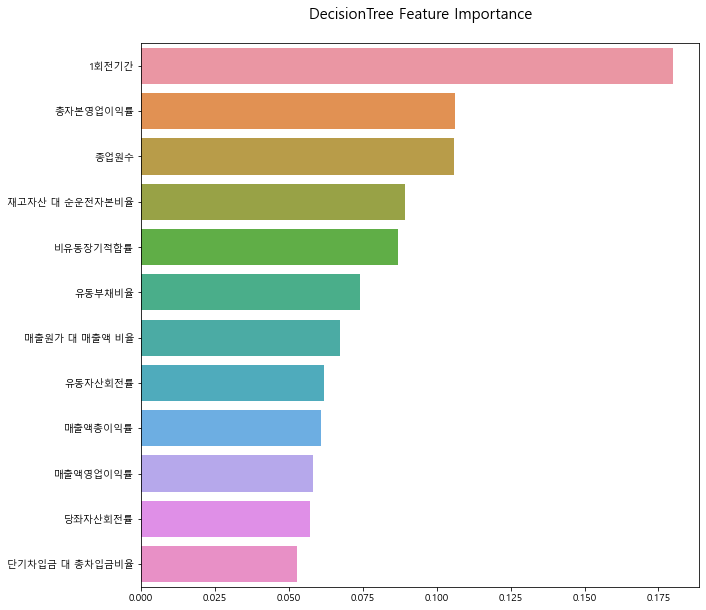

In [228]:
kosdaq_m0_dt = DecisionTree(kosdaq_M0_p)
kosdaq_m0_dt

,FI
유동자산회전률,0.20000
재고자산 대 순운전자본비율,0.18000
종업원수,0.14000
당좌자산회전률,0.08000
1회전기간,0.06000
매출액총이익률,0.06000
매출액영업이익률,0.06000
유동부채비율,0.06000
비유동장기적합률,0.04000
단기차입금 대 총차입금비율,0.04000


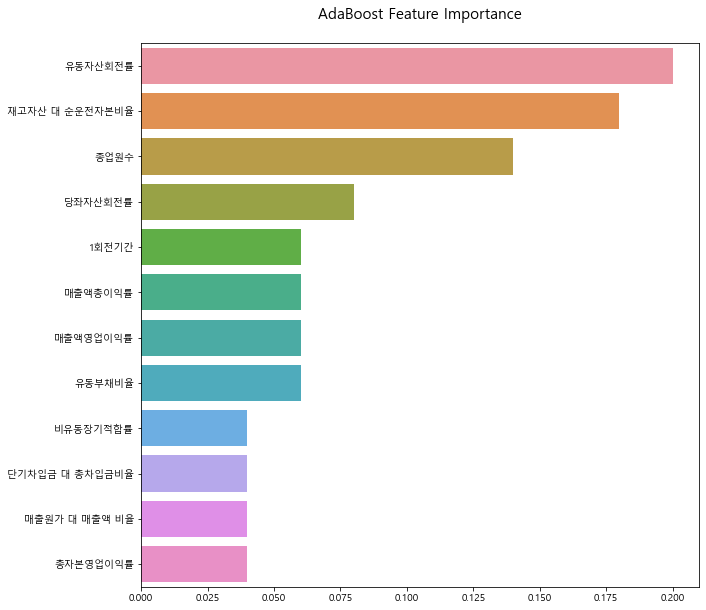

In [229]:
kosdaq_m0_ada = AdaBoost(kosdaq_M0_p)
kosdaq_m0_ada

In [230]:
kosdaq_m0_col = set(kosdaq_m0_xgb).union(set(kosdaq_m0_rf))
kosdaq_m0_col = kosdaq_m0_col.union(set(kosdaq_m0_dt))
kosdaq_m0_col = kosdaq_m0_col.union(set(kosdaq_m0_ada))
pd.DataFrame(kosdaq_m0_col)

,0
0,FI


In [231]:
# kosdaq_m0_col_remove = {'매출원가 대 매출액 비율', '당좌자산회전률', '매출액영업이익률'}
# kosdaq_m0_col = kosdaq_m0_col - kosdaq_m0_col_remove
# kosdaq_m0_col = list(kosdaq_m0_col)

# kosdaq_m0_col.append('target')
# kosdaq_M0_p = kosdaq_M0_wins[kosdaq_m0_col]
# kosdaq_M0_p

#### Dataset 저장

In [232]:
kosdaq_all_p.to_csv('./dataset/data_kosdaq_all.csv', encoding='utf-8', index=False)
kosdaq_M0_p.to_csv('./dataset/data_kosdaq_good.csv', encoding='utf-8', index=False)
kosdaq_M1_p.to_csv('./dataset/data_kosdaq_bad.csv', encoding='utf-8', index=False)

kospi_all_p.to_csv('./dataset/data_kospi_all.csv', encoding='utf-8', index=False)
kospi_M0_p.to_csv('./dataset/data_kospi_good.csv', encoding='utf-8', index=False)
kospi_M1_p.to_csv('./dataset/data_kospi_bad.csv', encoding='utf-8', index=False)